## Resources:
<ol>
<li> https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
<li> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
<li> http://xgboost.readthedocs.io/en/latest/model.html
<li> https://www.youtube.com/watch?v=ufHo8vbk6g4

</ol>

In [286]:
import pandas as pd
import numpy as np
import scipy as scp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import sklearn 
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [287]:
train = pd.read_csv('./data/Sber Bank/train.csv')
macro = pd.read_csv('./data/Sber Bank/macro.csv')
#train = pd.merge(train, macro, on='timestamp')

In [288]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

train.ix[train.full_sq <= 6, 'full_sq'] = np.nan
train.ix[train.life_sq <= 6, 'life_sq'] = np.nan

train.ix[train.full_sq > 2000, 'full_sq'] = np.nan
train.ix[train.life_sq > 2000, 'life_sq'] = np.nan

bad_index = [13117]
train.ix[bad_index, 'build_year'] = train.ix[bad_index, 'kitch_sq']
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = [10368, 11520, 13117, 21415, 28734]
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = train.ix[(train.num_room>=6) & (train.full_sq<100)].index
train.ix[bad_index, 'num_room'] = np.nan

bad_index = train.kitch_sq > train.life_sq
temp = train.ix[bad_index, 'kitch_sq']
train.ix[bad_index, 'kitch_sq'] = train.ix[bad_index, 'life_sq']
train.ix[bad_index, 'life_sq'] = temp

bad_index = train.kitch_sq > train.full_sq
temp = train.ix[bad_index, 'kitch_sq']
train.ix[bad_index, 'kitch_sq'] = train.ix[bad_index, 'full_sq']
train.ix[bad_index, 'full_sq'] = temp

bad_index = train.life_sq > train.full_sq
temp = train.ix[bad_index, 'life_sq']
train.ix[bad_index, 'life_sq'] = train.ix[bad_index, 'full_sq']
train.ix[bad_index, 'full_sq'] = temp

bad_index = train.floor > train.max_floor
temp = train.ix[bad_index, 'floor']
train.ix[bad_index, 'floor'] = train.ix[bad_index, 'max_floor']
train.ix[bad_index, 'max_floor'] = temp

train.ix[train.state > 30, 'state'] = np.nan

train.timestamp = pd.to_datetime(train.timestamp)
bad_index = (train.build_year == 0)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year
bad_index = (train.build_year == 1)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year-1
bad_index = (train.build_year == 3)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year-3
train.ix[train.build_year < 1600, 'build_year'] = np.nan
train.ix[train.build_year > 2018, 'build_year'] = np.nan

In [289]:
train['age'] = train['timestamp'].dt.year - train['build_year']

In [290]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values)) 
        train[c] = lbl.transform(list(train[c].values))

In [291]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
train = train.drop(['id', 'timestamp'], axis=1)
cols = train.columns
train = pd.DataFrame(imp.fit_transform(train))
train.columns = cols

# Machine Learning

## Prediction

In [292]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [293]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc'], axis=1), 
                                                    train['price_doc'], 
                                                    test_size=0.3, 
                                                    random_state=42)

print 'Length of X_train data: {}'.format(X_train.shape) 
print 'Length of y_train data: {}'.format(y_train.shape) 
print 'Length of X_test data:  {}'.format(X_test.shape)
print 'Length of y_test data:  {}'.format(y_test.shape) 

Length of X_train data: (21329, 290)
Length of y_train data: (21329L,)
Length of X_test data:  (9142, 290)
Length of y_test data:  (9142L,)


In [492]:
rf = RandomForestRegressor(max_depth=8, n_estimators=50, min_impurity_split=1e-7)
for i in range(1,5,1):
    rf.fit(X_train, y_train)
    print rf.score(X_test, y_test)

0.660069817885
0.650663528311
0.651588321979
0.658034601547


In [493]:
dtr = DecisionTreeRegressor(max_depth=8, min_samples_leaf=30, min_samples_split=42, min_impurity_split=1e-05)
for i in range(1,5,1):
    dtr.fit(X_train, y_train)
    print dtr.score(X_test, y_test)

0.582249012732
0.582227124377
0.582228611358
0.582228611358


In [497]:
ada = AdaBoostRegressor(n_estimators=110, learning_rate=0.01)
for i in range(1,5,1):
    ada.fit(X_train, y_train)
    print ada.score(X_test, y_test)

0.528075399632
0.528439794339
0.527947365738
0.530411562518


In [499]:
gbm = GradientBoostingRegressor(learning_rate=0.1)
for i in range(1,5,1):
    gbm.fit(X_train, y_train)
    print gbm.score(X_test, y_test)

0.680605645684
0.680362583396
0.681850561411
0.680436571236


## Linear Regression

#### Single test

In [58]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm = lm.predict(X_test)

y_lm[y_lm<0] = 0

## Decision Tree Regression

## Tree-Specific Parameters: 
These affect each individual tree in the model.

<ol>
<li>**splitter**

<li>**min_samples_split**
<ul>
<li>Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
<li>Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
<li>Too high values can lead to under-fitting hence, it should be tuned using CV.
</ul>

<li>**min_samples_leaf**
<ul>
<li>Defines the minimum samples (or observations) required in a terminal node or leaf.
<li>Used to control over-fitting similar to min_samples_split.
<li>Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
</ul>

<li>**min_weight_fraction_leaf**
<ul>
<li>Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.
Only one of #2 and #3 should be defined.
</ul>

<li>**max_depth**
<ul>
<li>The maximum depth of a tree.
<li>Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
</ul>

<li>**max_leaf_nodes**
<ul>
<li>The maximum number of terminal nodes or leaves in a tree.
<li>Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of $2^n$ leaves.
If this is defined, GBM will ignore max_depth.
</ul>

<li>**max_features**
<ul>
<li>The number of features to consider while searching for a best split. These will be randomly selected.
<li>As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
<li>Higher values can lead to over-fitting but depends on case to case.
</ul>
</ol>

In [349]:
from sklearn.tree import DecisionTreeRegressor

#### Cross Validation:

### Wide tuning:

In [364]:
dtr_params_3 = {'max_depth':[3,5,7,9,11,13], 
                'min_samples_split':range(2,1003, 200),
                'min_samples_leaf':range(1, 102, 20),
                'min_impurity_split':[1e-4, 1e-05, 1e-6, 1e-7]}

In [365]:
dtr_cv_3 = GridSearchCV(estimator=DecisionTreeRegressor(), 
                      param_grid=dtr_params_3, 
                      cv=5)
dtr_cv_3.fit(X_train, y_train)

print 'best params:\n{}\n'.format(dtr_cv_3.best_params_)

print 'best score:\n{}'.format(dtr_cv_3.best_score_)

best params:
{'min_samples_split': 2, 'min_impurity_split': 1e-05, 'max_depth': 9, 'min_samples_leaf': 21}

best score:
0.558709427874


In [366]:
dtr_cv_3.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(dtr_cv_3.best_estimator_.score(X_test, y_test))

y_dtr_cv = dtr_cv_3.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.587697823863
MSE: 2976246.39713


In [370]:
dtr_cv_df = pd.DataFrame(dtr_cv_3.cv_results_)
dtr_cv_df.to_csv('dtr_cv.csv')

### fine tuning

In [372]:
dtr_params_4 = {'max_depth':[8,9,10], 
                'min_samples_split':range(2,103, 10),
                'min_samples_leaf':[10, 15, 21, 25, 30, 35],
                'min_impurity_split':[1e-05]}

In [373]:
dtr_cv_fine = GridSearchCV(estimator=DecisionTreeRegressor(), 
                           param_grid=dtr_params_4, 
                           cv=5)
dtr_cv_fine.fit(X_train, y_train)

print 'best params:\n{}\n'.format(dtr_cv_fine.best_params_)

print 'best score:\n{}'.format(dtr_cv_fine.best_score_)

best params:
{'min_samples_split': 42, 'min_impurity_split': 1e-05, 'max_depth': 8, 'min_samples_leaf': 30}

best score:
0.56522205006


In [374]:
dtr_cv_fine.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(dtr_cv_fine.best_estimator_.score(X_test, y_test))

y_dtr_cv = dtr_cv_fine.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.582222122986
MSE: 2995944.67051


In [375]:
dtr_cv_fine_df = pd.DataFrame(dtr_cv_fine.cv_results_)
dtr_cv_df = dtr_cv_df.append(dtr_cv_fine_df)
dtr_cv_df.to_csv('dtr_cv.csv')

### tuning finer

In [376]:
dtr_params_5 = {'max_depth':[8], 
                'min_samples_split':[36, 38, 40, 42, 44, 46],
                'min_samples_leaf':[26, 28, 30, 32, 34],
                'min_impurity_split':[1e-05]}

In [377]:
dtr_cv_fine_1 = GridSearchCV(estimator=DecisionTreeRegressor(), 
                             param_grid=dtr_params_5, 
                             cv=5)
dtr_cv_fine_1.fit(X_train, y_train)

print 'best params:\n{}\n'.format(dtr_cv_fine_1.best_params_)

print 'best score:\n{}'.format(dtr_cv_fine_1.best_score_)

best params:
{'min_samples_split': 44, 'min_impurity_split': 1e-05, 'max_depth': 8, 'min_samples_leaf': 30}

best score:
0.565229250925


In [378]:
dtr_cv_fine_1.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(dtr_cv_fine_1.best_estimator_.score(X_test, y_test))

y_dtr_cv = dtr_cv_fine_1.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.582211092309
MSE: 2995984.22153


In [379]:
dtr_cv_fine_1_df = pd.DataFrame(dtr_cv_fine_1.cv_results_)
dtr_cv_df = dtr_cv_df.append(dtr_cv_fine_1_df)
dtr_cv_df.to_csv('dtr_cv.csv')

### CV. Analysis:

#### Time consumption

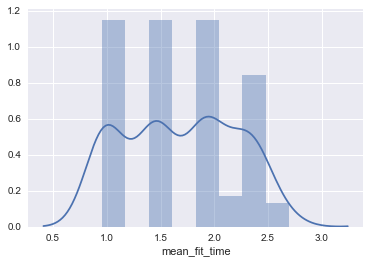

In [70]:
sns.distplot(dtr_cv_df.mean_fit_time)

In [75]:
dtr_cv_df.sort_values(by='mean_fit_time', ascending=False)[['mean_fit_time',
                                                           'param_max_depth', 
                                                           'param_min_impurity_split', 
                                                           'param_min_samples_leaf',
                                                           'param_min_samples_split']]

,mean_fit_time,param_max_depth,param_min_impurity_split,param_min_samples_leaf,param_min_samples_split
224,2.6946,10,1e-07,5,2
231,2.6604,10,1e-07,15,30
223,2.6256,10,1e-07,1,30
225,2.6064,10,1e-07,5,10
222,2.5700,10,1e-07,1,15
228,2.5680,10,1e-07,15,2
232,2.4962,10,1e-07,20,2
237,2.4674,10,1e-07,30,10
230,2.4660,10,1e-07,15,15
221,2.4550,10,1e-07,1,10


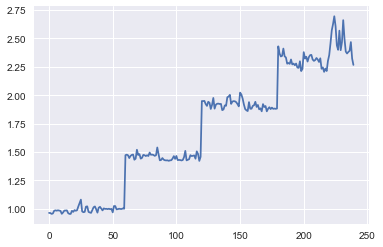

In [76]:
sns.plt.plot(dtr_cv_df.mean_fit_time)

#### Accuracy

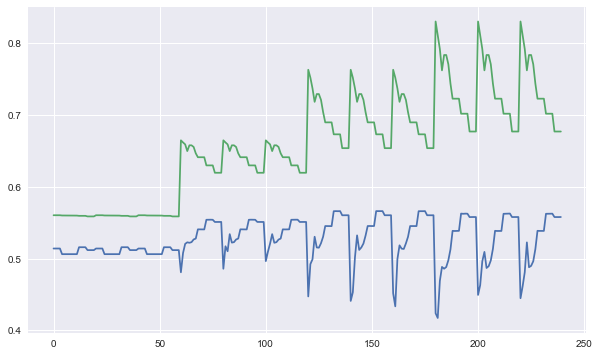

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
sns.plt.plot(dtr_cv_df.mean_test_score)
sns.plt.plot(dtr_cv_df.mean_train_score)

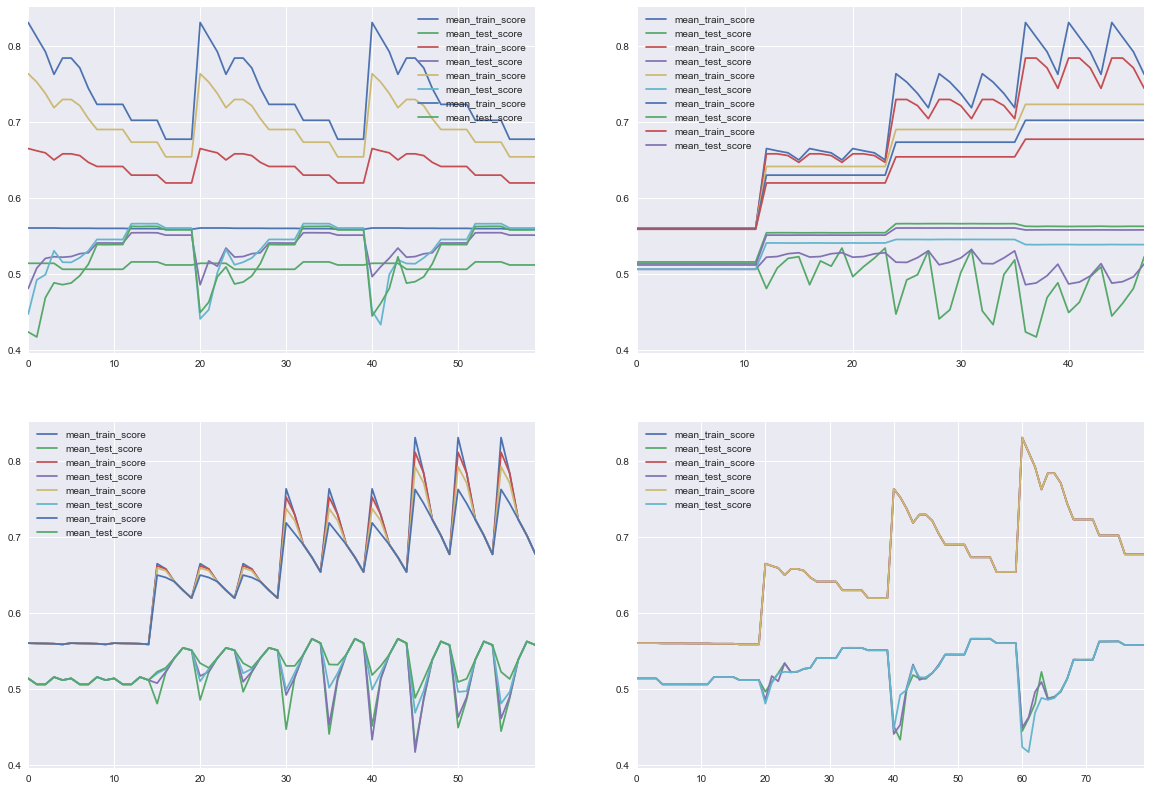

In [129]:
fig, ax = plt.subplots(2,2, figsize=[20,14])

for label, df in dtr_cv_df.groupby('param_max_depth'):
    df.reset_index()[['mean_train_score', 'mean_test_score']].plot(ax=ax[0,0], label=label)
    
for label, df in dtr_cv_df.groupby('param_min_samples_leaf'):
    df.reset_index()[['mean_train_score', 'mean_test_score']].plot(ax=ax[0,1], label=label)
    
for label, df in dtr_cv_df.groupby('param_min_samples_split'):
    df.reset_index()[['mean_train_score', 'mean_test_score']].plot(ax=ax[1,0], label=label)
    
for label, df in dtr_cv_df.groupby('param_min_impurity_split'):
    df.reset_index()[['mean_train_score', 'mean_test_score']].plot(ax=ax[1,1], label=label)

# Bagging

In [383]:
from sklearn.ensemble import BaggingRegressor

#### Cross Validation:

### Tuning depth

In [410]:
estimator=BaggingRegressor()
estimator.base_estimator

In [404]:
bg_params_1 = {#'max_depth':[4,6,8,10,12], 
               #'min_samples_split':[2], 
               #'min_samples_leaf':[1], 
               'n_estimators':[50, 250, 1000], 
               'max_samples':[1.0]}
               #'min_impurity_split':[1e-07]

In [412]:
bg_cv_depth = GridSearchCV(estimator=BaggingRegressor(), param_grid=bg_params_1, cv=5)
bg_cv_depth.fit(X_train, y_train)

print 'best params:\n{}\n'.format(bg_cv_depth.best_params_)

print 'best score:\n{}'.format(bg_cv_depth.best_score_)

TypeError: unbound method get_params() must be called with DecisionTreeRegressor instance as first argument (got nothing instead)

In [59]:
bg_cv_depth.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(bg_cv_depth.best_estimator_.score(X_test, y_test))

y_bgr_cv = bg_cv_depth.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_bgr_cv)**2))))

R2 score: 0.580012172281
MSE: 2998025.28133


# Random Forrest

In [417]:
from sklearn.ensemble import RandomForestRegressor

### Cross Validation:

### 1-Wide tuning `depth`

In [455]:
rf_params_1 = {'max_depth':range(4,17,2), 
               'min_samples_split':[2], 
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[250], 
               'min_impurity_split':[1e-07]}

In [456]:
rf_cv_depth = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_1, cv=5)
rf_cv_depth.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_depth.best_params_)

print 'best score:\n{}'.format(rf_cv_depth.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 16}

best score:
0.634205420944


In [457]:
rf_cv_depth.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_depth.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_depth.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.642122070434
MSE: 2772863.7311


In [458]:
rf_cv_depth_df = pd.DataFrame(rf_cv_depth.cv_results_)
rf_cv_df = rf_cv_depth_df
rf_cv_df.to_csv('rf_cv_df.csv')

### 2-tuning `depth` in high extreme

In [459]:
rf_params_2 = {'max_depth':[16, 18, 20], 
               'min_samples_split':[2], 
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[250], 
               'min_impurity_split':[1e-07]}

In [460]:
rf_cv_depth_2 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_2, cv=5)
rf_cv_depth_2.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_depth_2.best_params_)

print 'best score:\n{}'.format(rf_cv_depth_2.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 16}

best score:
0.636426412913


In [461]:
rf_cv_depth_2.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_depth_2.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_depth_2.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.639184589231
MSE: 2784220.3817


In [462]:
rf_cv_depth_2_df = pd.DataFrame(rf_cv_depth_2.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_depth_2_df)
rf_cv_df.to_csv('rf_cv_df.csv')

### 3-fine tuning `depth`

In [463]:
rf_params_3 = {'max_depth':[15,16,17], 
               'min_samples_split':[2], 
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[250], 
               'min_impurity_split':[1e-07]}

In [464]:
rf_cv_depth_fine = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_3, cv=5)
rf_cv_depth_fine.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_depth_fine.best_params_)

print 'best score:\n{}'.format(rf_cv_depth_fine.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 17}

best score:
0.638876751965


In [465]:
rf_cv_depth_fine.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_depth_fine.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_depth_fine.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.637178571989
MSE: 2791949.33736


In [466]:
rf_cv_depth_fine_df = pd.DataFrame(rf_cv_depth_fine.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_depth_fine_df)
rf_cv_df.to_csv('rf_cv_df.csv')

***
### 4-tuning `min_samples_split` and `min_samples_leaf`:

In [467]:
rf_params_4 = {'max_depth':[17], 
               'min_samples_split':range(2,1003, 200),
               'min_samples_leaf':range(1, 102, 20), 
               'max_features':['sqrt'], 
               'n_estimators':[250], 
               'min_impurity_split':[1e-07]}

In [468]:
rf_cv_samlping = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_4, cv=5)
rf_cv_samlping.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_samlping.best_params_)

print 'best score:\n{}'.format(rf_cv_samlping.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 17}

best score:
0.639391694045


In [469]:
rf_cv_samlping.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_samlping.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_samlping.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.637784314996
MSE: 2789617.73547


In [470]:
rf_cv_sampling_df = pd.DataFrame(rf_cv_samlping.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_sampling_df)
rf_cv_df.to_csv('rf_cv_df.csv')

### 5- tuning `n_estimator`:

In [471]:
rf_params_5 = {'max_depth':[17], 
               'min_samples_split':[2],
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[250, 500, 1500], 
               'min_impurity_split':[1e-07]}

In [472]:
rf_cv_n_estimator = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_5, cv=5)
rf_cv_n_estimator.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_n_estimator.best_params_)

print 'best score:\n{}'.format(rf_cv_n_estimator.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 17}

best score:
0.638663506203


In [473]:
rf_cv_n_estimator.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_n_estimator.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_n_estimator.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.640953342081
MSE: 2777387.73592


In [474]:
rf_cv_n_estimator_df = pd.DataFrame(rf_cv_n_estimator.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_n_estimator_df)
rf_cv_df.to_csv('rf_cv_df.csv')

### 5- further tuning of `n_estimator`:

In [475]:
rf_params_6 = {'max_depth':[17], 
               'min_samples_split':[2],
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[400, 500, 600, 700], 
               'min_impurity_split':[1e-07]}

In [476]:
rf_cv_n_estimator_2 = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_6, cv=5)
rf_cv_n_estimator_2.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_n_estimator_2.best_params_)

print 'best score:\n{}'.format(rf_cv_n_estimator_2.best_score_)

best params:
{'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 17}

best score:
0.638187269444


In [477]:
rf_cv_n_estimator_2.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_n_estimator_2.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_n_estimator_2.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.638660344672
MSE: 2786242.30557


In [478]:
rf_cv_n_estimator_2_df = pd.DataFrame(rf_cv_n_estimator_2.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_n_estimator_2_df)
rf_cv_df.to_csv('rf_cv_df.csv')

### 5- tuning `min_impurity_split`:

In [480]:
rf_params_7 = {'max_depth':[17], 
               'min_samples_split':[2],
               'min_samples_leaf':[1], 
               'max_features':['sqrt'], 
               'n_estimators':[500], 
               'min_impurity_split':[1e-5, 1e-6, 1e-07]}

In [481]:
rf_cv_impurity = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params_7, cv=5)
rf_cv_impurity.fit(X_train, y_train)

print 'best params:\n{}\n'.format(rf_cv_impurity.best_params_)

print 'best score:\n{}'.format(rf_cv_impurity.best_score_)

best params:
{'min_impurity_split': 1e-05, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 17}

best score:
0.638454906857


In [482]:
rf_cv_impurity.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(rf_cv_impurity.best_estimator_.score(X_test, y_test))

y_rf_cv = rf_cv_impurity.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_rf_cv)**2))))

R2 score: 0.639753905352
MSE: 2782022.95988


In [483]:
rf_cv_impurity_df = pd.DataFrame(rf_cv_impurity.cv_results_)
rf_cv_df = rf_cv_df.append(rf_cv_impurity_df)
rf_cv_df.to_csv('rf_cv_df.csv')

# Adaboost

In [496]:
from sklearn.ensemble import AdaBoostRegressor

#### Cross Validation:

In [172]:
ada_params = {'n_estimators':[80, 90, 100, 110], 
              'learning_rate':[0.01], 
              'loss':['linear'],
              'random_state':[15]}

In [173]:
ada = AdaBoostRegressor()
ada_cv = GridSearchCV(ada, ada_params, cv=5)
ada_cv.fit(X_train, y_train)

print 'best params:\n{}\n'.format(ada_cv.best_params_)

print 'best score:\n{}'.format(ada_cv.best_score_)

best params:
{'n_estimators': 110, 'loss': 'linear', 'learning_rate': 0.01, 'random_state': 15}

best score:
0.507965681328


In [174]:
ada_cv.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(ada_cv.best_estimator_.score(X_test, y_test))

y_ada_cv = ada_cv.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_ada_cv)**2))))

R2 score: 0.536340269533
MSE: 3150044.05862


In [182]:
ada_s = AdaBoostRegressor(n_estimators=60)
ada_s.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=60, random_state=None)

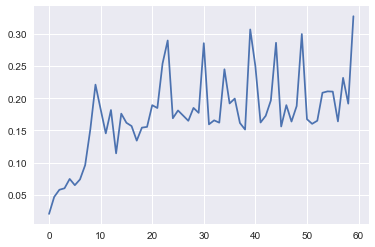

In [183]:
plt.plot(ada_s.estimator_errors_)

## Stagewise CV

In [185]:
ada_params = {'n_estimators':[80, 90, 100, 110], 
              'learning_rate':[0.1], 
              'loss':['linear'],
              'random_state':[15]}

In [186]:
ada_stage = AdaBoostRegressor()
ada_scv = GridSearchCV(ada_stage, ada_params, cv=5)
ada_scv.fit(X_train, y_train)

print 'best params:\n{}\n'.format(ada_scv.best_params_)

print 'best score:\n{}'.format(ada_scv.best_score_)

best params:
{'n_estimators': 110, 'loss': 'linear', 'learning_rate': 0.1, 'random_state': 15}

best score:
0.491345194508


In [187]:
ada_scv.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(ada_scv.best_estimator_.score(X_test, y_test))

y_ada_scv = ada_scv.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_ada_cv)**2))))

R2 score: 0.492028999005
MSE: 3150044.05862


In [188]:
ada_stage = AdaBoostRegressor(n_estimators=1100, learning_rate=0.01)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
<bound method AdaBoostRegressor.score of AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=1100, random_state=None)>


0.4960581536959443

In [190]:
ada_stage = AdaBoostRegressor(n_estimators=1500, learning_rate=0.01)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
0.480827230967


In [191]:
ada_stage = AdaBoostRegressor(n_estimators=1500, learning_rate=0.005)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
0.488759611015


In [188]:
ada_stage = AdaBoostRegressor(n_estimators=1100, learning_rate=0.01)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
<bound method AdaBoostRegressor.score of AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=1100, random_state=None)>


In [188]:
ada_stage = AdaBoostRegressor(n_estimators=1100, learning_rate=0.01)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
<bound method AdaBoostRegressor.score of AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=1100, random_state=None)>


In [188]:
ada_stage = AdaBoostRegressor(n_estimators=1100, learning_rate=0.01)
ada_stage.fit(X_train, y_train)

print 'best score:\n{}'.format(ada_stage.score(X_test, y_test))

best score:
<bound method AdaBoostRegressor.score of AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=1100, random_state=None)>


# Gradient Boosting 

## Boosting Parameters: 

These affect the boosting operation in the model.

<ol>
<li>**learning_rate**
<ul>
<li>This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
<li>Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
<li>Lower values would require higher number of trees to model all the relations and will be computationally expensive.
</ul>

<li>**n_estimators**
<ul>
<li>The number of sequential trees to be modeled (step 2)
Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.
</ul>

<li>**subsample**
<ul>
<li>The fraction of observations to be selected for each tree. Selection is done by random sampling.
<li>Values slightly less than 1 make the model robust by reducing the variance.
<li>Typical values ~0.8 generally work fine but can be fine-tuned further.
</ul>
</ol>

## miscellaneous parameters 
affect overall functionality:

<ol>
<li>**loss**
<ul>
<li>It refers to the loss function to be minimized in each split.
<li>It can have various values for classification and regression case. Generally the default values work fine. Other values should be chosen only if you understand their impact on the model.
</ul>

<li>**init**
<ul>
<li>This affects initialization of the output.
<li>This can be used if we have made another model whose outcome is to be used as the initial estimates for GBM.
</ul>

<li>**random_state**
<ul>
<li>The random number seed so that same random numbers are generated every time.
<li>This is important for parameter tuning. If we don’t fix the random number, then we’ll have different outcomes for subsequent runs on the same parameters and it becomes difficult to compare models.
<li>It can potentially result in overfitting to a particular random sample selected. We can try running models for different random samples, which is computationally expensive and generally not used.
</ul>

<li>**verbose**
<ul>
<li>The type of output to be printed when the model fits. The different values can be:
<ul>
<li>0: no output generated (default)
<li>1: output generated for trees in certain intervals
<li>>1: output generated for all trees
</ul>
</ul>

<li>**warm_start**
<ul>
<li>This parameter has an interesting application and can help a lot if used judicially.
<li>Using this, we can fit additional trees on previous fits of a model. It can save a lot of time and you should explore this option for advanced applications
</ul>

<li>**presort**
<ul>
<li>Select whether to presort data for faster splits.
<li>It makes the selection automatically by default but it can be changed if needed.
</ul>

In [284]:
from sklearn.ensemble import GradientBoostingRegressor

### Cross Validation:

I used bith train dataset only, and splitted 0.25 of the data as test set with nan-value handling. here 5-fold cross validation is used.

### 1-tune depth

In [294]:
gbm_params_1 = {'max_depth':range(5,16,2), 
              'min_samples_leaf':[1],
              'min_samples_split':[2], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [295]:
gbm_cv = GridSearchCV(estimator=GradientBoostingRegressor(), 
                      param_grid=gbm_params_1, 
                      cv=5)
gbm_cv.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv.best_params_)

print 'best score:\n{}'.format(gbm_cv.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 5}

best score:
0.656570036798


In [296]:
gbm_cv.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.674191716332
MSE: 2645709.33817


In [303]:
gbm_cv_stage_max_depth_wide_df = pd.DataFrame(gbm_cv.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_max_depth_wide_df
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 2- fine tune depth

In [298]:
gbm_params_2 = {'max_depth':[4,5,6], 
              'min_samples_leaf':[1],
              'min_samples_split':[2], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [299]:
gbm_cv_depth_fine = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_2, 
                                 cv=5)
gbm_cv_depth_fine.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_depth_fine.best_params_)

print 'best score:\n{}'.format(gbm_cv_depth_fine.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 250, 'min_samples_split': 2, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.660088472362


In [296]:
gbm_cv_depth_fine.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_depth_fine.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_depth_fine.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.674191716332
MSE: 2645709.33817


In [304]:
gbm_cv_stage_max_depth_fine_df = pd.DataFrame(gbm_cv_depth_fine.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_max_depth_fine_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 3-Tuning `min_samples_leaf` and `min_samples_split`:

In [310]:
gbm_params_3 = {'max_depth':[6], 
              'min_samples_leaf':range(1, 102, 20),
              'min_samples_split':range(2,1003, 200), 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [311]:
gbm_cv_sampling = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_3, 
                                 cv=5)
gbm_cv_sampling.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_sampling.best_params_)

print 'best score:\n{}'.format(gbm_cv_sampling.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 21, 'n_estimators': 250, 'min_samples_split': 2, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.673859371675


In [312]:
gbm_cv_sampling.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_sampling.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_sampling.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.678564376365
MSE: 2627895.38622


In [313]:
gbm_cv_stage_sampling_df = pd.DataFrame(gbm_cv_sampling.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_sampling_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 4-fine tuning `min_samples_leaf` and `min_samples_split`:

In [315]:
gbm_params_4 = {'max_depth':[6], 
              'min_samples_leaf':[17,19,21,23,25],
              'min_samples_split':[2,10,20,30,40,50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [316]:
gbm_cv_sampling_fine = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_4, 
                                 cv=5)
gbm_cv_sampling_fine.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_sampling_fine.best_params_)

print 'best score:\n{}'.format(gbm_cv_sampling_fine.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'n_estimators': 250, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.67447545916


In [317]:
gbm_cv_sampling_fine.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_sampling_fine.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_sampling_fine.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.676888012686
MSE: 2634739.02659


In [318]:
gbm_cv_stage_sampling_fine_df = pd.DataFrame(gbm_cv_sampling_fine.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_sampling_fine_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 5-fine tuning `min_samples_leaf` and `min_samples_split`:

In [320]:
gbm_params_5 = {'max_depth':[6], 
              'min_samples_leaf':[9,11,13,15,17],
              'min_samples_split':[50,60,70,80,90], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [321]:
gbm_cv_sampling_fine_2 = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_5, 
                                 cv=5)
gbm_cv_sampling_fine_2.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_sampling_fine_2.best_params_)

print 'best score:\n{}'.format(gbm_cv_sampling_fine_2.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'n_estimators': 250, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.67447545916


In [322]:
gbm_cv_sampling_fine_2.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_sampling_fine_2.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_sampling_fine_2.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.676888012686
MSE: 2634739.02659


In [323]:
gbm_cv_stage_sampling_fine_2_df = pd.DataFrame(gbm_cv_sampling_fine_2.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_sampling_fine_2_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 6-tuning `subsample`:

In [324]:
gbm_params_6 = {'max_depth':[6], 
              'min_samples_leaf':[17],
              'min_samples_split':[50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
              'max_features':['sqrt'],
              'n_estimators':[250],
              'learning_rate':[0.1],
              'random_state':[10]}

In [325]:
gbm_cv_subsampling = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_6, 
                                 cv=5)
gbm_cv_subsampling.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_subsampling.best_params_)

print 'best score:\n{}'.format(gbm_cv_subsampling.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'n_estimators': 250, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.67447545916


In [326]:
gbm_cv_subsampling.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_subsampling.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_subsampling.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.676888012686
MSE: 2634739.02659


In [327]:
gbm_cv_stage_subsampling_df = pd.DataFrame(gbm_cv_subsampling.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_subsampling_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 7-tuning `n_estimator`:

In [328]:
gbm_params_7 = {'max_depth':[6], 
              'min_samples_leaf':[17],
              'min_samples_split':[50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':range(50,251,50),
              'learning_rate':[0.1],
              'random_state':[10]}

In [329]:
gbm_cv_n_estimator = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_7, 
                                 cv=5)
gbm_cv_n_estimator.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_n_estimator.best_params_)

print 'best score:\n{}'.format(gbm_cv_n_estimator.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.1, 'min_samples_leaf': 17, 'n_estimators': 250, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.67447545916


In [330]:
gbm_cv_n_estimator.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_n_estimator.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_n_estimator.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.676888012686
MSE: 2634739.02659


In [335]:
gbm_cv_stage_n_estimator_df = pd.DataFrame(gbm_cv_n_estimator.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_n_estimator_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 8-tuning `n_estimator` and `learning_rate`:

In [332]:
gbm_params_8 = {'max_depth':[6], 
              'min_samples_leaf':[17],
              'min_samples_split':[50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[2500],
              'learning_rate':[0.01],
              'random_state':[10]}

In [333]:
gbm_cv_lrn = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_8, 
                                 cv=5)
gbm_cv_lrn.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_lrn.best_params_)

print 'best score:\n{}'.format(gbm_cv_lrn.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.01, 'min_samples_leaf': 17, 'n_estimators': 2500, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.68256142332


In [334]:
gbm_cv_lrn.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_lrn.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_lrn.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.693403456835
MSE: 2566520.25543


In [336]:
gbm_cv_stage_lrn_df = pd.DataFrame(gbm_cv_lrn.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_lrn_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 9-tuning `n_estimator` and `learning_rate`:

In [338]:
gbm_params_9 = {'max_depth':[6], 
              'min_samples_leaf':[17],
              'min_samples_split':[50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[5000],
              'learning_rate':[0.005],
              'random_state':[10]}

In [339]:
gbm_cv_lrn_2 = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_9, 
                                 cv=5)
gbm_cv_lrn_2.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_lrn_2.best_params_)

print 'best score:\n{}'.format(gbm_cv_lrn_2.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.005, 'min_samples_leaf': 17, 'n_estimators': 5000, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.683890121469


In [340]:
gbm_cv_lrn_2.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_lrn_2.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_lrn_2.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.692143723912
MSE: 2571787.46391


In [341]:
gbm_cv_stage_lrn_2_df = pd.DataFrame(gbm_cv_lrn_2.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_lrn_2_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

### 10-tuning `learning_rate`:

In [342]:
gbm_params_10 = {'max_depth':[6], 
              'min_samples_leaf':[17],
              'min_samples_split':[50], 
              'min_impurity_split':[1e-07],
              'subsample':[0.8],
              'max_features':['sqrt'],
              'n_estimators':[2500],
              'learning_rate':[0.01, 0.005],
              'random_state':[10]}

In [343]:
gbm_cv_lrn_3 = GridSearchCV(estimator=GradientBoostingRegressor(), 
                                 param_grid=gbm_params_10, 
                                 cv=5)
gbm_cv_lrn_3.fit(X_train, y_train)

print 'best params:\n{}\n'.format(gbm_cv_lrn_3.best_params_)

print 'best score:\n{}'.format(gbm_cv_lrn_3.best_score_)

best params:
{'subsample': 0.8, 'min_impurity_split': 1e-07, 'learning_rate': 0.01, 'min_samples_leaf': 17, 'n_estimators': 2500, 'min_samples_split': 50, 'random_state': 10, 'max_features': 'sqrt', 'max_depth': 6}

best score:
0.68256142332


In [344]:
gbm_cv_lrn_3.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(gbm_cv_lrn_3.best_estimator_.score(X_test, y_test))

y_dtr_cv = gbm_cv_lrn_3.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_dtr_cv)**2))))

R2 score: 0.693403456835
MSE: 2566520.25543


In [346]:
gbm_cv_stage_lrn_3_df = pd.DataFrame(gbm_cv_lrn_3.cv_results_)
gbm_cv_stage_df = gbm_cv_stage_df.append(gbm_cv_stage_lrn_3_df)
gbm_cv_stage_df.to_csv('gbm_cv_stage.csv')

# Xgboost

I used bith train dataset only, and splitted 0.25 of the data as test set without nan-value handling. here 5-fold cross validation is used.

## General Parameters

These define the overall functionality of XGBoost.

<ol>
<li>**booster** [default=gbtree]
<ul>
<li>Select the type of model to run at each iteration. It has 2 options:
<ul>
<li>gbtree: tree-based models
<li>gblinear: linear models
</ul>
</ul>

<li>**silent** [default=0]:
<ul>
<li>Silent mode is activated is set to 1, i.e. no running messages will be printed.
<li>It’s generally good to keep it 0 as the messages might help in understanding the model.
</ul>

<li>**nthread** [default to maximum number of threads available if not set]
<ul>
<li>This is used for parallel processing and number of cores in the system should be entered
<li>If you wish to run on all cores, value should not be entered and algorithm will detect automatically
</ul>

</ol>

## Booster Parameters

Though there are 2 types of boosters, I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

<ol>

<li>**eta** [default=0.3]
<ul>
<li>Analogous to learning rate in GBM
<li>Makes the model more robust by shrinking the weights on each step
<li>Typical final values to be used: 0.01-0.2
</ul>

<li>**min_child_weight** [default=1]
<ul>
<li>Defines the minimum sum of weights of all observations required in a child.
<li>This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
<li>Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the <li>particular sample selected for a tree.
<li>Too high values can lead to under-fitting hence, it should be tuned using CV.
</ul>

<li>**max_depth** [default=6]
<ul>
<li>The maximum depth of a tree, same as GBM.
<li>Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
<li>Should be tuned using CV.
<li>Typical values: 3-10
</ul>

<li>**max_leaf_nodes**
<ul>
<li>The maximum number of terminal nodes or leaves in a tree.
<li>Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
<li>If this is defined, GBM will ignore max_depth
</ul>

<li>**gamma** [default=0]
<ul>
<li>A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
<li>Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
</ul>

<li>**max_delta_step** [default=0]
<ul>
<li>In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
<li>Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
<li>This is generally not used but you can explore further if you wish.
</ul>
<li>**subsample** [default=1]
<ul>
<li>Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
<li>Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
<li>Typical values: 0.5-1
</ul>

<li>**colsample_bytree** [default=1]
<ul>
<li>Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
<li>Typical values: 0.5-1
</ul>

<li>**colsample_bylevel** [default=1]
<ul>
<li>Denotes the subsample ratio of columns for each split, in each level.
<li>I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
</ul>

<li>**lambda** [default=1]
<ul>
<li>L2 regularization term on weights (analogous to Ridge regression)
<li>This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
</ul>

<li>**alpha** [default=0]
<ul>
<li>L1 regularization term on weight (analogous to Lasso regression)
<li>Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
</ul>

<li>**scale_pos_weight** [default=1]
<ul>
<li>A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
</ul>

</ol>

## Learning Task Parameters

These parameters are used to define the optimization objective the metric to be calculated at each step.

<ol>

<li>**objective** [default=reg:linear]
<ul>
<li>This defines the loss function to be minimized. Mostly used values are:
<ul>
<li>**binary**:logistic –logistic regression for binary classification, returns predicted probability (not class)
<li>**multi**:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
<li>**multi**:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
</ul>
</ul>

<li>**eval_metric** [ default according to objective ]
<ul>
<li>The metric to be used for validation data.
<li>The default values are rmse for regression and error for classification.
<li>Typical values are:
<ul>
<li>**rmse** – root mean square error
<li>**mae** – mean absolute error
<li>**logloss** – negative log-likelihood
<li>**error** – Binary classification error rate (0.5 threshold)
<li>**merror** – Multiclass classification error rate
<li>**mlogloss** – Multiclass logloss
<li>**auc**: Area under the curve
</ul>
</ul>

<li>**seed** [default=0]
<ul>
<li>The random number seed.
<li>Can be used for generating reproducible results and also for parameter tuning.
</ul>

#### Cross Validation:

In [119]:
from xgboost import XGBRegressor

In [120]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

In [151]:
xgb_cv_stage_df = pd.DataFrame()

### 1- initial guess:
Here a set of parameters are chosen and based on that, the optimum `n_estimator` parameter is found by xgb.cv() API. Thie optimum n_estimator is when the model performance doesn't grow for at least succesive `early_stopping_rounds` iteration (here 50 rounds).

In [170]:
xgb_params_1 = {'max_depth':5,
                'gamma':0,
                'subsample':0.8,
                'colsample_bytree':0.8,
                'reg_lambda':0,
                'reg_alpha':0,
                'learning_rate':0.1
                }

In [171]:
cv_output = xgb.cv(xgb_params_1, 
                   dtrain,
                   folds=5,
                   num_boost_round=1000,
                   early_stopping_rounds=50
                   )

In [172]:
n_estimator_1 = cv_output.shape[0]
n_estimator_1

173

### 2-Tune `max_depth`:
As the most prameter, `max_depth` is tuned in a wide gridy search.

In [195]:
xgb_params_2 = {'max_depth':[3,5,7,9],
                'gamma':[0],
                'subsample':[0.8],                                             
                'colsample_bytree':[0.8],
                'reg_lambda':[0],
                'reg_alpha':[0],
                'learning_rate':[0.1]}

In [196]:
xgr_cv_wide_max_depth = GridSearchCV(estimator=XGBRegressor(n_estimators=n_estimator_1), param_grid=xgb_params_2, cv=5)
xgr_cv_wide_max_depth.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_wide_max_depth.best_params_)

print 'best score:\n{}'.format(xgr_cv_wide_max_depth.best_score_)

best params:
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.680974891015


In [197]:
xgr_cv_wide_max_depth.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_wide_max_depth.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_wide_max_depth.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.700077497709
MSE: 2538432.35443


In [212]:
xgb_cv_stage_max_depth_wide_df = pd.DataFrame(xgr_cv_wide_max_depth.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_max_depth_wide_df
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')

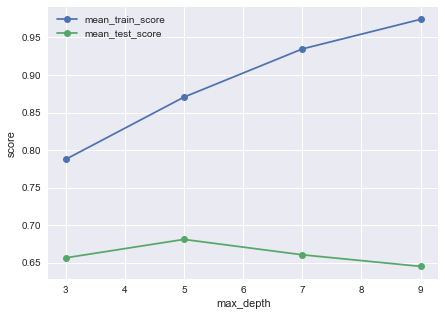

In [199]:
plt.subplots(figsize=[7,5])
plt.plot(xgb_cv_stage_max_depth_wide_df['param_max_depth'], xgb_cv_stage_max_depth_wide_df['mean_train_score'], '-o')
plt.plot(xgb_cv_stage_max_depth_wide_df['param_max_depth'], xgb_cv_stage_max_depth_wide_df['mean_test_score'], '-o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()

### 3-Fine tune the `max_depth`:
Now 

In [205]:
xgb_params_3 = {'max_depth':[4,5,6],
                'gamma':[0],
                'subsample':[0.8],                                             
                'colsample_bytree':[0.8],
                'reg_lambda':[0],
                'reg_alpha':[0],
                'learning_rate':[0.1]}

In [206]:
xgr_cv_fine_max_depth = GridSearchCV(estimator=XGBRegressor(n_estimator=n_estimator_1), 
                      param_grid=xgb_params_3, 
                      cv=5)
xgr_cv_fine_max_depth.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_fine_max_depth.best_params_)

print 'best score:\n{}'.format(xgr_cv_fine_max_depth.best_score_)

best params:
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.678352834182


In [207]:
xgr_cv_fine_max_depth.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_fine_max_depth.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_fine_max_depth.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820047306
MSE: 2552180.05039


In [213]:
xgb_cv_stage_max_depth_fine_df = pd.DataFrame(xgr_cv_fine_max_depth.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_max_depth_fine_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,0.002608,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,0.002332,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,0.001744,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,0.002871,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,0.003098,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,0.000980,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,0.005004,0.033046,0.001300


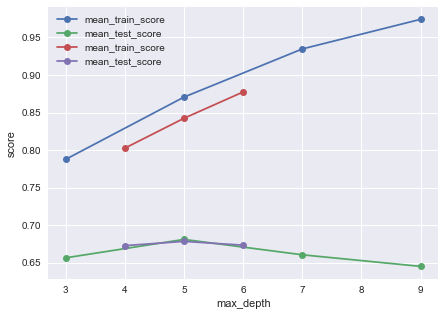

In [217]:
plt.subplots(figsize=[7,5])
plt.plot(xgb_cv_stage_max_depth_wide_df['param_max_depth'], xgb_cv_stage_max_depth_wide_df['mean_train_score'], '-o')
plt.plot(xgb_cv_stage_max_depth_wide_df['param_max_depth'], xgb_cv_stage_max_depth_wide_df['mean_test_score'], '-o')
plt.plot(xgb_cv_stage_max_depth_fine_df['param_max_depth'], xgb_cv_stage_max_depth_fine_df['mean_train_score'], '-o')
plt.plot(xgb_cv_stage_max_depth_fine_df['param_max_depth'], xgb_cv_stage_max_depth_fine_df['mean_test_score'], '-o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()

### 4- tune `n_estimator`:

In [22]:
xgb_params_4 = {'max_depth':6,
                'gamma':0,
                'subsample':0.8,
                'colsample_bytree':0.8,
                'learning_rate':0.1
                }

In [23]:
cv_output = xgb.cv(xgb_params_4, 
                   dtrain,
                   folds=5,
                   num_boost_round=1000,
                   early_stopping_rounds=50
                   )

In [24]:
cv_output.shape

(139, 4)

### tune `gamma`:

In [218]:
xgb_params_4 = {'max_depth':[5],
                'gamma':[i/10.0 for i in range(0,5)],
                'subsample':[0.8],                                             
                'colsample_bytree':[0.8],
                'reg_lambda':[0],
                'reg_alpha':[0],
                'learning_rate':[0.1]}

In [219]:
xgr_cv_gamma = GridSearchCV(estimator=XGBRegressor(n_estimator=n_estimator_1), 
                            param_grid=xgb_params_4,
                            cv=5)
xgr_cv_gamma.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_gamma.best_params_)

print 'best score:\n{}'.format(xgr_cv_gamma.best_score_)

best params:
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0.0}

best score:
0.678352834182


In [220]:
xgr_cv_gamma.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_gamma.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_gamma.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820047306
MSE: 2552180.05039


In [221]:
xgb_cv_stage_gamma_df = pd.DataFrame(xgr_cv_gamma.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_gamma_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,0.002608,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,0.002332,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,0.001744,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,0.002871,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,0.003098,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,0.000980,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,0.005004,0.033046,0.001300
0,26.1038,0.0672,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.526047,0.002482,0.034248,0.003471
1,26.4730,0.0700,0.678353,0.842286,0.8,0.1,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.058648,0.004561,0.034248,0.003471
2,26.3774,0.0706,0.678353,0.842286,0.8,0.2,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.108083,0.002939,0.034248,0.003471


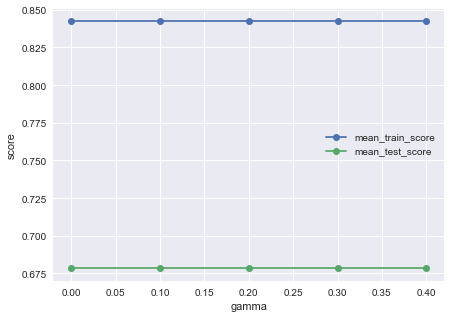

In [222]:
plt.subplots(figsize=[7,5])
plt.plot(xgb_cv_stage_gamma_df['param_gamma'], xgb_cv_stage_gamma_df['mean_train_score'], '-o')
plt.plot(xgb_cv_stage_gamma_df['param_gamma'], xgb_cv_stage_gamma_df['mean_test_score'], '-o')
plt.xlabel('gamma')
plt.ylabel('score')
plt.legend()

### tune `subsample` and `colsample_bytree`:

In [223]:
xgb_params_5 = {'max_depth':[5],
                'gamma':[0],
                'subsample':[i/10.0 for i in range(6,10)],
                'colsample_bytree':[i/10.0 for i in range(6,10)],
                'reg_lambda':[0],
                'reg_alpha':[0],
                'learning_rate':[0.1]}

In [224]:
xgr_cv_sampling = GridSearchCV(estimator=XGBRegressor(n_estimator=n_estimator_1), 
                              param_grid=xgb_params_5,
                              cv=5)
xgr_cv_sampling.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_sampling.best_params_)

print 'best score:\n{}'.format(xgr_cv_sampling.best_score_)

best params:
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.678352834182


In [225]:
xgr_cv_sampling.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_sampling.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_sampling.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820047306
MSE: 2552180.05039


In [226]:
xgb_cv_stage_sampling_df = pd.DataFrame(xgr_cv_sampling.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_sampling_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,0.002608,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,0.002332,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,0.001744,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,0.002871,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,0.003098,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,0.000980,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,0.005004,0.033046,0.001300
0,26.1038,0.0672,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.526047,0.002482,0.034248,0.003471
1,26.4730,0.0700,0.678353,0.842286,0.8,0.1,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.058648,0.004561,0.034248,0.003471
2,26.3774,0.0706,0.678353,0.842286,0.8,0.2,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.108083,0.002939,0.034248,0.003471


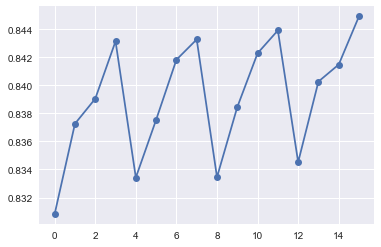

In [230]:
plt.plot(xgb_cv_stage_sampling_df['mean_train_score'], '-o')

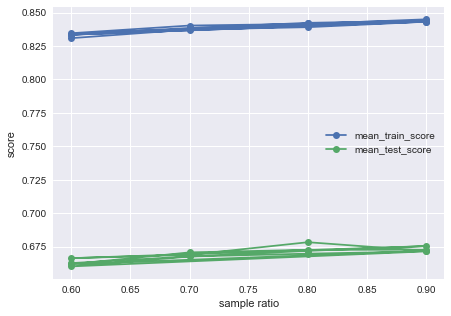

In [231]:
plt.subplots(figsize=[7,5])
#plt.plot(xgb_cv_stage_sampling_df['param_subsample'], xgb_cv_stage_sampling_df['mean_train_score'], '-o')
#plt.plot(xgb_cv_stage_sampling_df['param_subsample'], xgb_cv_stage_sampling_df['mean_test_score'], '-o')
#plt.plot(xgb_cv_stage_sampling_df['param_colsample_bytree'], xgb_cv_stage_sampling_df['mean_train_score'], '-o')
#plt.plot(xgb_cv_stage_sampling_df['param_colsample_bytree'], xgb_cv_stage_sampling_df['mean_test_score'], '-o')
plt.xlabel('sample ratio')
plt.ylabel('score')
plt.legend()

### Fine tune  `subsample` and `colsample_bytree`:

In [232]:
xgb_params_6 = {'max_depth':[5],
                'gamma':[0],
                'subsample':[0.75, 0.8, 0.85],
                'colsample_bytree':[0.75, 0.8, 0.85],
                'reg_lambda':[0],
                'reg_alpha':[0],
                'learning_rate':[0.1]}

In [233]:
xgr_cv_sampling_fine = GridSearchCV(estimator=XGBRegressor(n_estimator=n_estimator_1), 
                      param_grid=xgb_params_6,
                      cv=5)
xgr_cv_sampling_fine.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_sampling_fine.best_params_)

print 'best score:\n{}'.format(xgr_cv_sampling_fine.best_score_)

best params:
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.678352834182


In [234]:
xgr_cv_sampling_fine.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_sampling_fine.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_sampling_fine.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820047306
MSE: 2552180.05039


In [235]:
xgb_cv_stage_sampling_fine_df = pd.DataFrame(xgr_cv_sampling_fine.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_sampling_fine_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,0.002608,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,0.002332,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,0.001744,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,0.002871,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,0.003098,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,0.000980,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,0.005004,0.033046,0.001300
0,26.1038,0.0672,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.526047,0.002482,0.034248,0.003471
1,26.4730,0.0700,0.678353,0.842286,0.8,0.1,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.058648,0.004561,0.034248,0.003471
2,26.3774,0.0706,0.678353,0.842286,0.8,0.2,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.108083,0.002939,0.034248,0.003471


### Tune `reg_alpha` and `reg_lambda`:

In [239]:
xgb_params_7 = {'max_depth':[5],
                'gamma':[0],
                'subsample':[0.8],
                'colsample_bytree':[0.8],
                'reg_lambda':[0, 1e-2, 0.1, 1, 100],
                'reg_alpha':[0, 1e-2, 0.1, 1, 100],
                'learning_rate':[0.1]}

In [240]:
xgr_cv_reg = GridSearchCV(estimator=XGBRegressor(n_estimator=n_estimator_1), 
                          param_grid=xgb_params_7,
                          cv=5)
xgr_cv_reg.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_reg.best_params_)

print 'best score:\n{}'.format(xgr_cv_reg.best_score_)

best params:
{'reg_alpha': 0.01, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.67835283435


In [242]:
xgr_cv_reg.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_reg.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_reg.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820046976
MSE: 2552180.05178


In [243]:
xgb_cv_stage_reg_df = pd.DataFrame(xgr_cv_reg.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_reg_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,2.607620e-03,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,2.332355e-03,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,1.743521e-03,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,2.870548e-03,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,3.098393e-03,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,9.797249e-04,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,5.003973e-03,0.033046,0.001300
0,26.1038,0.0672,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.526047,2.481924e-03,0.034248,0.003471
1,26.4730,0.0700,0.678353,0.842286,0.8,0.1,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.058648,4.560737e-03,0.034248,0.003471
2,26.3774,0.0706,0.678353,0.842286,0.8,0.2,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.108083,2.939343e-03,0.034248,0.003471


### Tune `learning_rate`:

In [246]:
xgb_params_7 = {'max_depth':[5],
                'gamma':[0],
                'subsample':[0.8],
                'colsample_bytree':[0.8],
                'reg_lambda':[0],
                'reg_alpha':[1e-2],
                'learning_rate':[1, 0.1, 0.01]}

In [247]:
xgr_cv_lrn = GridSearchCV(estimator=XGBRegressor(n_estimator=1600), 
                          param_grid=xgb_params_7,
                          cv=5)
xgr_cv_lrn.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv_lrn.best_params_)

print 'best score:\n{}'.format(xgr_cv_lrn.best_score_)

best params:
{'reg_alpha': 0.01, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_lambda': 0, 'max_depth': 5, 'gamma': 0}

best score:
0.67835283435


In [248]:
xgr_cv_lrn.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv_lrn.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv_lrn.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.696820046976
MSE: 2552180.05178


In [249]:
xgb_cv_stage_lrn_df = pd.DataFrame(xgr_cv_lrn.cv_results_)
xgb_cv_stage_df = xgb_cv_stage_df.append(xgb_cv_stage_lrn_df) 
xgb_cv_stage_df.to_csv('xgb_cv_stage.csv')
xgb_cv_stage_df

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_alpha,param_reg_lambda,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.8584,0.0620,0.656412,0.787552,0.8,0,0.1,3,0,0,...,0.675586,0.784735,0.590715,0.790803,0.644799,0.791432,0.441058,2.607620e-03,0.038850,0.004222
1,43.4614,0.0854,0.680975,0.870488,0.8,0,0.1,5,0,0,...,0.685836,0.866043,0.619229,0.875772,0.682124,0.873135,1.005358,2.332355e-03,0.034342,0.003539
2,59.3396,0.1104,0.660458,0.934656,0.8,0,0.1,7,0,0,...,0.637288,0.932737,0.610216,0.935234,0.661353,0.935862,0.660953,1.743521e-03,0.034441,0.001085
3,77.8956,0.1414,0.645021,0.974137,0.8,0,0.1,9,0,0,...,0.611027,0.973648,0.600294,0.973263,0.651165,0.976252,1.087716,2.870548e-03,0.040956,0.001073
0,20.0384,0.0590,0.672685,0.802445,0.8,0,0.1,4,0,0,...,0.694818,0.800290,0.605602,0.805942,0.666697,0.805864,0.355507,3.098393e-03,0.038251,0.002993
1,24.6652,0.0648,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.201461,9.797249e-04,0.034248,0.003471
2,32.8694,0.0814,0.673282,0.877363,0.8,0,0.1,6,0,0,...,0.675936,0.875947,0.620117,0.878109,0.667643,0.879335,0.771334,5.003973e-03,0.033046,0.001300
0,26.1038,0.0672,0.678353,0.842286,0.8,0,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.526047,2.481924e-03,0.034248,0.003471
1,26.4730,0.0700,0.678353,0.842286,0.8,0.1,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.058648,4.560737e-03,0.034248,0.003471
2,26.3774,0.0706,0.678353,0.842286,0.8,0.2,0.1,5,0,0,...,0.678173,0.838749,0.618598,0.845641,0.678248,0.846964,0.108083,2.939343e-03,0.034248,0.003471


### Intensive grid search

I used bith train and macro database, and splitted 0.2 of the data as test set. here 3-fold cross validation is used.

In [72]:
xgb_params_10 = {'learning_rate':[1, 0.1, 0.05, 0.01],
                 'max_depth':[3,5,7,9],
                 'gamma':[0],
                 'subsample':[0.7, 0.8, 0.9],
                 'colsample_bytree':[0.6, 0.7, 0.8]}

In [73]:
xgr_cv = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_params_10)
xgr_cv.fit(X_train, y_train)

print 'best params:\n{}\n'.format(xgr_cv.best_params_)

print 'best score:\n{}'.format(xgr_cv.best_score_)

best params:
{'subsample': 0.9, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0}

best score:
0.673883185903


In [74]:
xgr_cv.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(xgr_cv.best_estimator_.score(X_test, y_test))

y_xgr_cv = xgr_cv.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_xgr_cv)**2))))

R2 score: 0.712747276718
MSE: 2479413.81264


In [79]:
xgb_cv_intensive_df = pd.DataFrame(xgr_cv.cv_results_)
xgb_cv_intensive_df.to_csv('xgb_cv_intensive_df.csv')

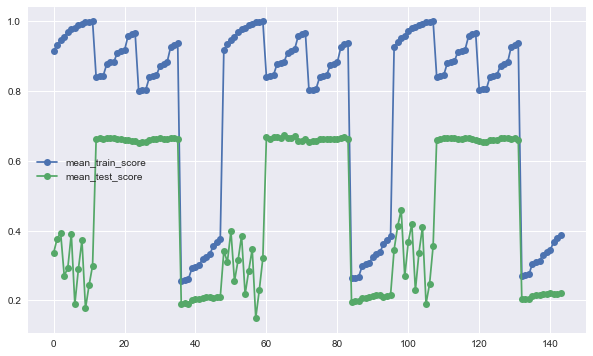

In [94]:
plt.subplots(figsize=[10,6])
plt.plot(xgb_cv_intensive_df.mean_train_score, '-o')
plt.plot(xgb_cv_intensive_df.mean_test_score, '-o')
plt.legend()

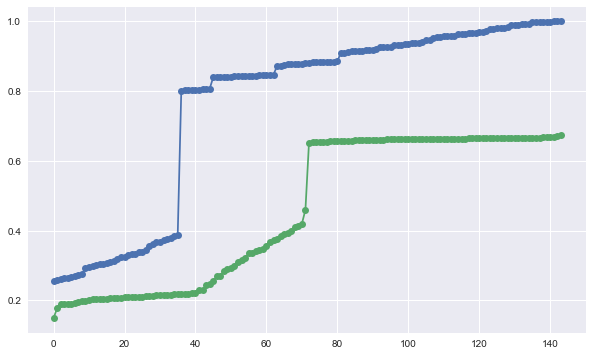

In [96]:
plt.subplots(figsize=[10,6])
plt.plot(xgb_cv_intensive_df.mean_train_score.sort_values().values, '-o')
plt.plot(xgb_cv_intensive_df.mean_test_score.sort_values().values, '-o')
plt.legend()

mean fit time: 40.676545
mean score time: 0.184414


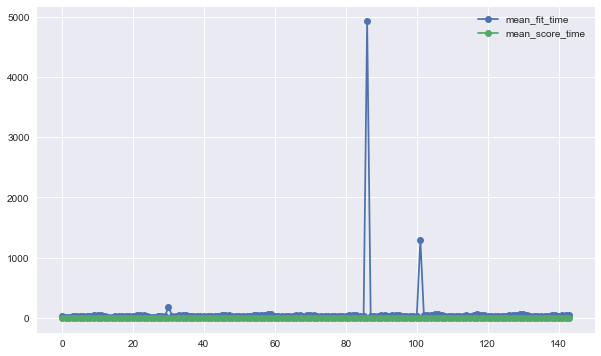

In [101]:
print 'mean fit time: %f' % xgb_cv_intensive_df.mean_fit_time[xgb_cv_intensive_df.mean_fit_time<1000].values.mean()
print 'mean score time: %f' % xgb_cv_intensive_df.mean_score_time.mean()
plt.subplots(figsize=[10,6])
plt.plot(xgb_cv_intensive_df.mean_fit_time, '-o')
plt.plot(xgb_cv_intensive_df.mean_score_time, '-o')
plt.legend()

In [106]:
list(xgb_cv_intensive_df[xgb_cv_intensive_df.mean_fit_time>1000].params)

[{'colsample_bytree': 0.7,
  'gamma': 0,
  'learning_rate': 0.01,
  'max_depth': 5,
  'subsample': 0.9},
 {'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 1,
  'max_depth': 6,
  'subsample': 0.9}]

### Lightgbm
Most decision tree learning algorithms grow tree by level(depth)-wise, like the following image:
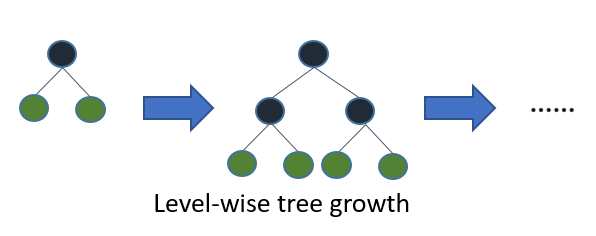
LightGBM grows tree by leaf-wise(best-first). It will choose the leaf with max delta loss to grow. When growing same #leaf, Leaf-wise algorithm can reduce more loss than level-wise algorithm. Leaf-wise may cause over-fitting when #data is small. So, LightGBM can use an additional parameter max_depth to limit depth of tree and avoid over-fitting.
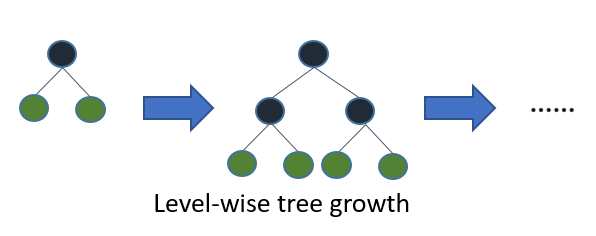

In [277]:
lgb_params  = {'boosting_type':['gbdt'], 
               'num_leaves':[128], 
               'max_depth':[7], 
               'learning_rate':[0.1, 1],
               'n_estimators':[1000], 
               'max_bin':[255], 
               'subsample_for_bin':[50000], 
               #'objective':[None], 
               'min_split_gain':[0], 
               'min_child_weight':[5], 
               'min_child_samples':[10],
               'bagging_fraction': [0.95],
               'bagging_freq': [1],
               'subsample':[1], 
               'subsample_freq':[1], 
               'colsample_bytree':[1], 
               'reg_alpha':[0.1],
               'reg_lambda':[10, 100], 
               'seed':[0]}

In [278]:
lgb_cv = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=lgb_params)
lgb_cv.fit(X_train, y_train)

print 'best params:\n{}\n'.format(lgb_cv.best_params_)

print 'best score:\n{}'.format(lgb_cv.best_score_)

best params:
{'num_leaves': 128, 'reg_alpha': 0.1, 'subsample_for_bin': 50000, 'colsample_bytree': 1, 'subsample_freq': 1, 'bagging_fraction': 0.95, 'learning_rate': 0.1, 'min_child_weight': 5, 'min_split_gain': 0, 'n_estimators': 1000, 'subsample': 1, 'reg_lambda': 100, 'seed': 0, 'max_bin': 255, 'min_child_samples': 10, 'bagging_freq': 1, 'max_depth': 7, 'boosting_type': 'gbdt'}

best score:
0.0192781578457


In [258]:
lgb_cv.best_estimator_.fit(X_train, y_train)
print 'R2 score: {}'.format(lgb_cv.best_estimator_.score(X_test, y_test))

y_lgb_cv = lgb_cv.best_estimator_.predict(X_test)
print 'MSE: {}'.format(np.sqrt(np.mean(((y_test - y_lgb_cv)**2))))

R2 score: -2.46923871965e-05
MSE: 4635178.15392
